# Group Project: Pulsar Star Data 

### Introduction 

##### What are Pulsar Stars?

Pulsar stars are a very rare type of Neutron star that produce radio emission detectable on Earth. As pulsar stars rotate rapidly, their emission beam sweeps across the sky, producing a detectable pattern of broadband radio emission that repeats periodically. As such, pulsar search involves looking for periodic radio signals with large radio telescopes.

Each pulsar produces a slightly different emission pattern, which varies slightly with each rotation. Within the data set, each potential signal detection is known as a “candidate”. The “candidate” is then averaged over many rotations of the pulsar, as determined by the length of an observation. In the absence of additional info, each candidate could potentially describe a real pulsar. However, as pulsar stars are detected using large radio telescopes, other radio signals are also picked up in this way, causing confusion in identifying which waves come from pulsars and which are noise. Almost all detections in practice are caused by radio frequency interference (RFI) and noise, making legitimate signals hard to find.  

##### The Dataset

The HTRU2 dataset contains data about pulsars, both examples caused by RFI and/or noise, and real pulsar examples. Legitimate pulsar examples are a minority positive class, and spurious examples the majority negative class. The dataset contains a total of 17,898 samples of radio signals. This is an imbalanced dataset: 1,639 are real pulsar wave patterns while 16,259 are non-pulsar signals.

Each candidate is described by 8 continuous variables, and a single class variable. Although the data file does not contain column names, they can be round in the readme attached in the .zip. The first four are simple statistics obtained from the integrated pulse profile, an array of continuous variables that describe a longitude-resolved version of the signal that has been averaged in both time and frequency. The remaining four variables are similarly obtained from the DM-SNR curve, a Dispersion Measure - Signal- to-Noise Ratio curve that is obtained through the pulsar star signal. The 8 variables are as such: 

Mean of the integrated profile.

Standard deviation of the integrated profile.

Excess kurtosis of the integrated profile.

Skewness of the integrated profile.

Mean of the DM-SNR curve.

Standard deviation of the DM-SNR curve.

Excess kurtosis of the DM-SNR curve.

Skewness of the DM-SNR curve.

Each row lists the variables first, and the class label is the final entry. The class labels used are 0 (negative) and 1 (positive). 

##### The Question

Trying to predict whether certain data given is a pulsar star or not??? 



#### Method

- split data into training and testing data (with respect to the ratio of real and not real puslar stars)
- specify which variable we will use 
- standardize (scale center) all variables
- fold?
- find out which k is most optimal to use 
- build model with best k
- confusion matrix?

#### Expected Outcomes and Significance 

- expect to find - a model with high accuracy?
- could filter whether or not a certain signal is a pulsar or random radio noise?
- what makes a pulsar and radio noise different? 

In [120]:
library(tidyverse)
library(testthat)
library(digest)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 10)

In [56]:
# all code comments are prompts to help with writing explanations/markdown comments

## Methods:
For our proposal, we'll aim to build a classification system using the __K-nearest neighbours algorithm__. In the following code, we'll load our data, clean it and set up the foundations for our model to be built on.

Since R uses randomness for many of it's data training functions, and we want our work to be reproducible, we can use `set.seed()` so R continues to use the same sequences of randomness.

In [135]:
set.seed(77)

In [59]:
# Explain column name abbreviations (and meaning too? if word count allows)

In [60]:
# reading in data via unzip
# renaming columns since orig. data had no column names

# elaboration of unzipping the file:
# Create a temp. file name (eg tempfile())
# Use download.file() to fetch the file into the temp. file
# Use unz() to extract the target file from temp. file
# Remove the temp file via unlink()

# make sure you explicitly mention that the file is readable from the web

Our data is hosted on the UCI Machine Learing Repository in a compressed format, so we'll need to download and decompress the data using the `download.file()` and `unz()` functions respectively. Past that, we can use our standard `read_csv()` function with `col_names = FALSE` to indicate that our data does not include column names.

We can manually fetch, abbreviate and `rename()` the column names from the data's associated `Readme.txt` file and apply them to our data with the `rename()` function. We also `mutate()` our status column to a factor for future use in classification functions.

In [71]:
temp <- tempfile()       # declaring a temporary file
download.file("https://archive.ics.uci.edu/ml/machine-learning-databases/00372/HTRU2.zip", temp)
conn <- unz(temp, "HTRU_2.csv")
data <- read_csv(conn, col_names = FALSE)
unlink(temp)             # scrapping our temporary file
data <- rename(data,
               mean = X1,
               st_dev = X2,
               e_kurtosis = X3,
               skewness = X4,
               snr_mean = X5,
               snr_st_dev = X6,
               snr_e_kurtosis = X7,
               snr_skewness = X8,
               status = X9) |>
    mutate(status = as_factor(status))
data

Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): X1, X2, X3, X4, X5, X6, X7, X8, X9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


mean,st_dev,e_kurtosis,skewness,snr_mean,snr_st_dev,snr_e_kurtosis,snr_skewness,status
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.56250,55.68378,-0.23457141,-0.6996484,3.199833,19.11043,7.975532,74.24222,0
102.50781,58.88243,0.46531815,-0.5150879,1.677258,14.86015,10.576487,127.39358,0
103.01562,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191,0
136.75000,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,0
88.72656,40.67223,0.60086608,1.1234917,1.178930,11.46872,14.269573,252.56731,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
136.4297,59.84742,-0.1878456,-0.73812297,1.296823,12.16606,15.450260,285.931022,0
122.5547,49.48561,0.1279781,0.32306090,16.409699,44.62689,2.945244,8.297092,0
119.3359,59.93594,0.1593631,-0.74302540,21.430602,58.87200,2.499517,4.595173,0


In [72]:
# checking how many rows with missing values
# explain what we might do if there are any

In [73]:
missing_vals <- sum(is.na(data))
missing_vals

[1] 0

In [74]:
# there are no missing values therefore we dont need to take the steps we said we might have otherwise needed to

In [75]:
# split the data into training and testing
# explain why we do this (generic explanation)

In [76]:
data_split <- initial_split(data, prop = 0.75, strata = status)
data_train <- training(data_split)
data_test <- testing(data_split)

In [77]:
# describe what class bias means
# here we are counting the data points in each class to decide whether we need to correct for class bias

In [78]:
counts <- data_train |>
    group_by(status) |>
    summarize(n=n())

counts

status,n
<fct>,<int>
0,12205
1,1218


In [79]:
# There are many more non pulsars than pulsars
# we will upsample to correct for class bias

In [132]:
library(caret)
data_balanced <- upSample(x = data_train[, -ncol(data_train)] , y = data_train$status, yname = "status")
data_balanced
counts_balanced <- data_balanced |>
    group_by(status) |>
    summarize(n = n())

counts_balanced

mean,st_dev,e_kurtosis,skewness,snr_mean,snr_st_dev,snr_e_kurtosis,snr_skewness,status
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.56250,55.68378,-0.23457141,-0.6996484,3.1998328,19.110426,7.975532,74.24222,0
103.01562,39.34165,0.32332837,1.0511644,3.1212375,21.744669,7.735822,63.17191,0
136.75000,57.17845,-0.06841464,-0.6362384,3.6429766,20.959280,6.896499,53.59366,0
93.57031,46.69811,0.53190485,0.4167211,1.6362876,14.545074,10.621748,131.39400,0
119.48438,48.76506,0.03146022,-0.1121676,0.9991639,9.279612,19.206230,479.75657,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
16.53906,35.78362,5.413670,30.129618,82.32776,66.87172,0.6194808,-0.354825,1
101.07812,48.58749,1.011427,1.151870,81.88796,81.46414,0.4851051,-1.117904,1
83.85938,56.45307,1.518645,1.619664,121.75084,82.99607,-0.5066625,-1.419887,1


status,n
<fct>,<int>
0,12205
1,12205


In [133]:
#plotting unbalanced and balanced data to demonstrate oversampling


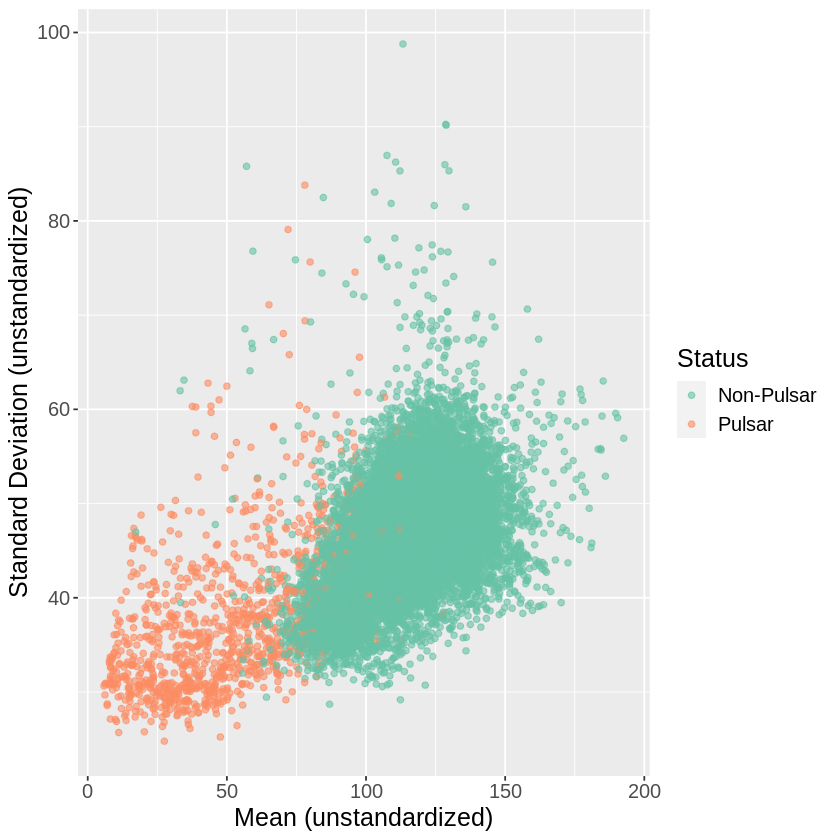

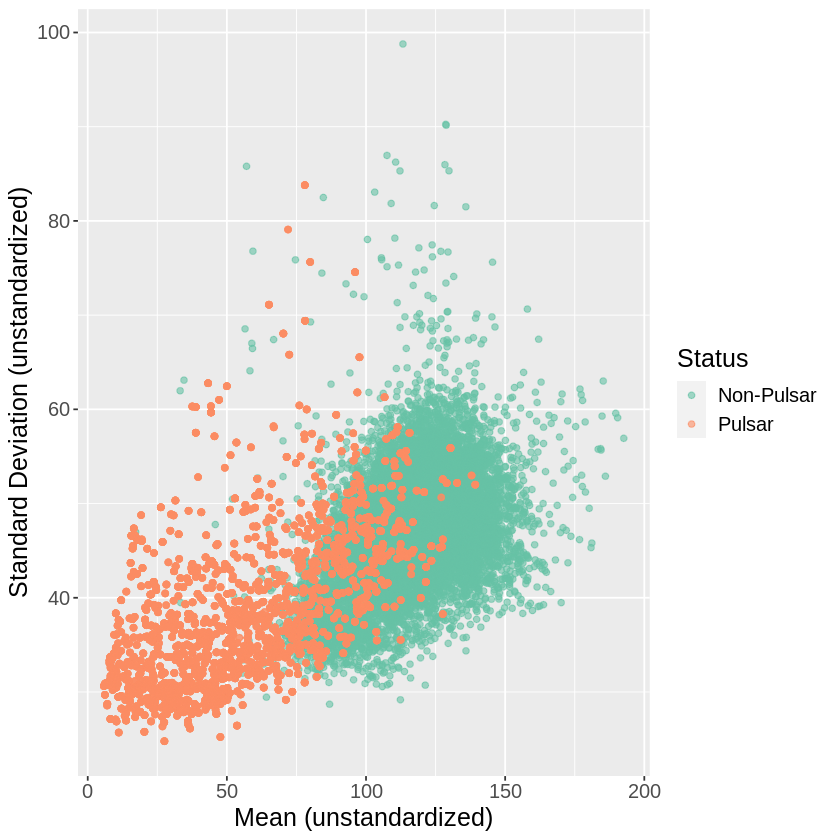

In [134]:
library(gridExtra)

par(mfcol=c(1,2))

mean_stdev_orig <- data_train |>
  ggplot(aes(x = mean, y = st_dev, color = status)) +
  geom_point(alpha = 0.6) +
  labs(x = "Mean (unstandardized)", 
       y = "Standard Deviation (unstandardized)",
       color = "Status") +
    scale_color_brewer(palette = "Set2", labels = c("Non-Pulsar", "Pulsar")) +
  theme(text = element_text(size = 15))

mean_stdev_bal <- data_balanced |>
  ggplot(aes(x = mean, y = st_dev, color = status)) +
  geom_point(alpha = 0.6) +
  labs(x = "Mean (unstandardized)", 
       y = "Standard Deviation (unstandardized)",
       color = "Status") +
    scale_color_brewer(palette = "Set2", labels = c("Non-Pulsar", "Pulsar")) +
  theme(text = element_text(size = 15))

mean_stdev_orig
mean_stdev_bal